<a href="https://colab.research.google.com/github/tobiasgobel/PDFviewer/blob/main/VQE_grid_opt_clifford_gates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sympy.series import series
from scipy.optimize import minimize, NonlinearConstraint
import time
import itertools
from sympy import symbols, Matrix, SparseMatrix, cos, sin, expand, lambdify, O
from sympy.utilities.iterables import multiset_permutations
from scipy.linalg import expm, sinm, cosm
from functools import *
from operator import *
import scipy
import sympy
import numpy as np
import random
import math
from numba import jit
import matplotlib.pyplot as plt

In [4]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' %(f.__name__, te-ts))
        return result
    return wrap

In [5]:

def pauli_on_pauli(p1,p2):
    
    if p1 == 'X' and p2 == 'Y':
        return 1j, 'Z'
    elif p1 == 'X' and p2 == 'X':
        return 1, 'I'
    elif p1 == 'Y' and p2 == 'Y':
        return 1, 'I'
    elif p1 == 'Z' and p2 == 'Z':
        return 1, 'I'
    elif p1 == 'Z' and p2 == 'X':
        return 1j, 'Y'
    elif p1 == 'Z' and p2 == 'Y':
        return -1j, 'X'
    elif p1 == 'I':
        return 1, p2
    elif p2 == 'I':
        return 1, p1
    else:
        a, p = pauli_on_pauli(p2,p1)
        return -1*a, p

def single_pauli_action(pauli, spin):
    
    if pauli=='X':
        return((spin+1)%2, 1)
    elif pauli=='Y':
        return((spin+1)%2, 1j*(-1)**spin)
    elif pauli=='Z':
        return(spin, (-1)**spin)
    elif pauli=='I':
        return(spin, 1)
    else:
        print('wrong pauli!')
        return(None)

def findCombinationsUtil(li, arr, index, num, reducedNum):
    z = []
    if (reducedNum < 0): 
        return; 
    if (reducedNum == 0): 
  
        for i in range(index): 
            z = z + [arr[i]]
        li.append(z) 
        return;

    prev = 1 if (index == 0) else arr[index - 1]; 
  
    for k in range(prev, num + 1): 
          

        arr[index] = k; 
  
        findCombinationsUtil(li,arr, index + 1, num,  
                                 reducedNum - k); 
    return li

def k_all(N, generators, order): 
      
    # array to store the combinations 
    # It can contain max n elements
    out = []
    k_length = len(generators)
    for k in range(1, order+1):
        arr = [0] * k;
        output = []
        a =  findCombinationsUtil([], arr, 0, k, k);
        for i in a:
            if len(i)<= k_length:
                i = i.extend((k_length-len(i))*[0])
        for j in a:
            if len(j) == k_length:
#                 if k_vector(N, interactions,j).state()[1] != N*[0]:
                output = output + list(multiset_permutations(j))
        out =  out+ output
    return [tuple(p) for p in [[0]*k_length] + out]

def power_product(x,y):
    out = 1
    for i in range(len(x)):
         out*= x[i]**y[i]
    return out



In [6]:
@timing
@jit(nopython=True)
def Energy_eigen(H):
  result = np.linalg.eig(H)
  index = np.argmin(result[0])
  return result[0][index],result[1][index]

def Energy_matrix(thetas,N,H,ansatz, K):

  #build psi
  a = np.eye(2**N)
  zero_state = np.zeros(2**N)
  zero_state[0]=1
  for i in range(len(ansatz)-1,-1,-1):
    T = ansatz[i]
    exp = expm(1j*(np.pi/4*K[i]+thetas[i])*T)
    a = a @ exp
  

  psi = a @ zero_state
  
  #build Hamiltonian
  Energy = (np.transpose((np.conj(psi)) @ (H @ (psi))))

  return np.real(Energy)

def psi(thetas, ansatz,K):
    #build psi
  a = np.eye(2**N)
  zero_state = np.zeros(2**N)
  zero_state[0]=1
  for i in range(len(ansatz)-1,-1,-1):
    T = ansatz[i]
    exp = expm(1j*(np.pi/4*K[i]+thetas[i])*T)
    a = a @ exp
  

  psi = a @ zero_state
  
  return psi

  

In [7]:
Pauli = {"X":np.array([[0,1],[1,0]]), "Z": np.array([[1,0],[0,-1]]),"Y":np.array([[0,-1j],[1j,0]]), "I":np.eye(2)}

class pauli:
  def __init__(self,string, N, factor = 1):
    self.string = string
    self.factor = factor
    self.N = N
    self.starting_state = np.array([0]*self.N)


  def __str__(self):
    return self.string+".   factor: "+str(self.factor)
    
  #define multiplying by a constant (on left hand side)
  def __rmul__(self, c):
    return pauli(self.string,self.N, c*self.factor)

  #define the power of a pauli string
  def __pow__(self, c): 
    C = pauli("I0",self.N)
    for i in range(abs(c)):
      C = C*self
    return C

  #define multiplying two pauli strings
  def __mul__(self, x):
    pos1, pauli1 = self.split()
    pos2, pauli2 = x.split()
    factor = self.factor*x.factor
    string = ""
    counter1 =0
    counter2 =0

    for j in range(self.N):
      end1 = counter1 == len(pos1)
      end2 = counter2 == len(pos2)

      if not end1 and not end2:
        if int(pos1[counter1]) == j and int(pos2[counter2]) == j:
          a, p= pauli_on_pauli(pauli1[counter1],pauli2[counter2])
          factor *= a
          string+= p+str(j)
          counter1+=1
          counter2+=1
        elif int(pos1[counter1]) == j:
          string+=pauli1[counter1]+str(j)
          counter1+=1
        elif int(pos2[counter2]) == j:
          string+=pauli2[counter2]+str(j)
          counter2+=1
      elif not end1:
        if int(pos1[counter1]) == j:
          string+=pauli1[counter1]+str(j)
          counter1+=1
      elif not end2:
          if int(pos2[counter2]) == j:
            string+=pauli2[counter2]+str(j)
            counter2+=1
      else:
        pass
      
    return pauli(string, self.N, factor)

  #calculate resulting state of paulistring when acted upon initial_state  
  def state(self, initial_state = 0):
    pos, pauli = self.split()
    init_state = self.starting_state + initial_state
    a = self.factor
    for j in range(len(pos)):
      Pauli = pauli[j]
      spin = init_state[int(pos[j])]
      new_spin, factor = single_pauli_action(Pauli,spin)
      init_state[int(pos[j])] = new_spin
      a *= factor
    return a, tuple(init_state)

    
#creating lists of operators and corresponding positions
  def split(self):
    pauli_lst = []
    pos_lst = []
    prev_int = False
    for k in self.string:
        if k.isdigit():
            if not prev_int:
                pos_lst.append(k)
            else:
                pos_lst[-1] += k
            prev_int = True
        else:
            pauli_lst.append(k)
            prev_int = False
    return pos_lst, pauli_lst
  
  def matrix_repr(self):
    positions, paulis = self.split()
    Kron = 1
    counter = 0
    for j in range(self.N):
      if counter == len(positions):
        for _ in range(self.N-j):
          Kron = np.kron(Kron, np.eye(2))
        break

      elif j == int(positions[counter]):
        Kron = np.kron(Kron, Pauli[paulis[counter]])
        counter+=1
      else:
          Kron = np.kron(Kron, np.eye(2))

    return Kron*self.factor
  
print(pauli("X0X1Y2",3,7).matrix_repr())
  

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-7.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+7.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-7.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+7.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-7.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+7.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-7.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+7.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [8]:
#gives result of transformation exp(-i*T1)*T2*exp(i*T2)
def Clifford_map(T1, T2, reversed_arguments = True):
  global ansatz
  T1T2 = T1*T2
  T2T1 = T2*T1
  if T1T2.factor == T2T1.factor:
    if reversed_arguments:
      return T1
    else:
      return T2
  elif T1T2.factor == -T2T1.factor:
    if reversed_arguments:
      return -1j*T2T1
    else:
      return -1j*T1T2
  else:
    return "something wrong here"


#returns list of pauli objects that are the result 
#of pulling all clifford gates to the left
def pull_cliffords_through(ansatz, K, N):
  T_K = [ansatz[0]]
  
  for j in range(1, len(ansatz)):
    T = ansatz[j]
    for i in range(j-1,-1,-1):
      for _ in range(abs(K[i])):
        T = Clifford_map(T,ansatz[i])
    T_K += [T] 
  return T_K





In [9]:

def s_dict(N, ansatz, K, order):
  start = time()
  s_dict = {} #keys: possible bitstrings, values dictionary with orders
  T_K = pull_cliffords_through(ansatz, K, N)
  K_all = list(map(tuple, itertools.product([0, 1], repeat=len(ansatz))))

  for i in K_all: #loop through all 
    
    #calculate state that is produced by T_i
    pauli_string = power_product(T_K[::-1], i[::-1])
    factor, state = pauli_string.state()
    #calculate magnitude of term
    term = (1j)**sum(i)*factor
    #check whether binary string is in dictionary, otherwise add
    if state not in s_dict:
      s_dict[state] = {}
    if sum(i) not in s_dict[state]:
      s_dict[state][sum(i)] = ([list(i)],[term])
    else:
      current = s_dict[state][sum(i)]
      current[0].append(list(i))
      current[1].append(term)

  #make np.array
  for st in s_dict:
    for som in s_dict[st]:
      lst = s_dict[st][som]
      s_dict[st][som] = (np.array(lst[0]),np.array(lst[1]))
  
  return s_dict


def G_k(N, H, ansatz, K):
  g_k = []

  #Initialize list of Clifford gates with respective power of K.
  G_K = []
  for i in range(len(K)):
    G_K += [np.sign(K[i])*ansatz[i]]*abs(K[i])
  for P in H:
    # G_K = [ansatz[i]**K[i] for i in range(len(K))]
    #Apply nested Clifford Map to obtain G^-K P_a G^K
    paulistring = reduce(Clifford_map, [P]+G_K[::-1])
    g_k += [paulistring]
  return g_k

@jit(nopython=True)
def dict_multiplication(k,values,thetas):
  sum = 0
  for i in range(k.shape[0]):
    product = 1
    for j in range(k.shape[1]):
      product*=(np.cos(thetas[j]))**(-k[i,j]+1)*(np.sin(thetas[j]))**k[i,j]
    sum += product*values[i]
  return sum

def Normalize(s_d, thetas, order):
  sum = 0
  for s in s_d:
    for o in s_d[s]:
      for o1 in range(order -o+1):
        if o1 in s_d[s]:
          k, values = s_d[s][o]
          k1, values1 = s_d[s][o1]
          factor = dict_multiplication(k,values,thetas)
          factor1 = dict_multiplication(k1,values1,thetas)
          sum += np.conj(factor1)*factor

  return sum



In [10]:

def energy(thetas,ansatz, s_dict,G_K, order):
  E = 0
  s_dict1 = s_dict
  for paulistring in G_K: #loop through terms in Hamiltonian
    E_a = 0
    #loop over basis states
    for s in s_dict1:
      E_a_s = 0
    
      #Calculate G^-K P_a G^K |s>
      a, state = paulistring.state(s)
      #Define contributions of |s> and |s'>
      psi_s1 = s_dict1[s]

      #Check if the state created by hamiltonian, exists in wavefunction
      try:
        psi_s2 = s_dict1[state]
      except:
        break
      #Double for loop to take the right orders in perturbation theory
      for o1 in psi_s1:
        for o2 in range(order - o1 +1):
          if o2 in psi_s2:
            A = dict_multiplication(psi_s1[o1][0],psi_s1[o1][1],thetas)
            B = dict_multiplication(psi_s2[o2][0],psi_s2[o2][1],thetas)
            E_a_s += A*np.conj(B)

      E_a_s *= a
      E_a += E_a_s
    E += E_a
  
  norm = Normalize(s_dict1, thetas, order)
  # print(f"E:{E}, Norm{norm}, E_final:{E/norm}")
  return np.real(E/norm)

In [11]:
def angle_compare(theta_opt, theta_appr, K):
  theta_appr = theta_appr + np.array(K)*np.pi/4
  theta_appr = theta_appr % (2*np.pi)
  theta_opt = theta_opt % (2*np.pi)

  distance = np.linalg.norm(theta_opt-theta_appr)
  
  return distance

def wavefunction_compare(theta_opt, theta_appr, K, ansatz):
  wave_1 = psi(theta_opt, ansatz, [0]*len(ansatz))
  wave_2 = psi(theta_appr, ansatz, K)
  distance = np.linalg.norm(wave_1-wave_2)
  return distance


In [12]:
#initialize

# N = 1
# t = 6*np.pi/8
# Z_h = -np.cos(t)
# X_h = -np.sin(t)
# ansatz = [pauli("Y0",N)]
# H = [pauli("Z0",N,Z_h),pauli("X0",N,X_h)]



N = 2
Z_h = -1
X_h = -10
ansatz = [pauli("X0X1",N),pauli("Z0",N),pauli("Z1",N)]
H = [pauli("Z0",N,Z_h),pauli("Z1",N,Z_h)]
H+= [pauli("X0X1",N,X_h)]

# N = 4
# Z_h = -1
# X_h = -10
# ansatz = [pauli("Y0X1",N),pauli("Y1X2",N),pauli("Y2X3",N)]
# H = [pauli("Z0",N,Z_h),pauli("Z1",N,Z_h),pauli("Z2",N,Z_h),pauli("Z3",N,Z_h)]
# H+= [pauli("X0X1",N,X_h),pauli("X1X2",N,X_h),pauli("X2X3",N,X_h)]



# N = 3
# Z_h = -1
# X_h = -3
# ansatz = [pauli("X0Y1",N),pauli("X1Y2",N)]*2
# H = [pauli("Z0",N,Z_h),pauli("Z1",N,Z_h),pauli("Z2",N,Z_h)]
# H+= [pauli("X0X1",N,X_h),pauli("X1X2",N,X_h)]




H_m = sum([h.matrix_repr() for h in H])
ansatz_m = [a.matrix_repr() for a in ansatz]

iters = 10
K_init = [0]*len(ansatz)
theta_init = (np.random.random(len(ansatz))-.5)*.4
K_path = []
tracking_dictionary = {}
order = 2*len(ansatz)
# order = 6
epsilon = 2**-5
bounds = [(-3*np.pi/8,3*np.pi/8)]*len(ansatz)


global_min = scipy.optimize.minimize(Energy_matrix, theta_init, jac = False, args = (N,H_m,ansatz_m, K_init))
print(f"Lowest Energy of ansatz: {global_min.fun}, angles: {global_min.x}")

for i in range(iters):

  print(f"iteration:{i}")
  print(f"K = {K_init}")
  K_path+=[K_init.copy()]
  s = s_dict(N, ansatz, K_init, order)
  G_K = G_k(N, H, ansatz,K_init)
  result = scipy.optimize.minimize(energy, theta_init,jac = False, args = (ansatz,s,G_K,order))
  

  max_index = np.argmax(np.abs(result.x))
  print(f"angles={result.x}, {max_index}")
  print(f"largest angle: {np.abs(result.x[max_index])/np.pi} *pi")
  print(f"Energy intermediate={result.fun}")
  print(f"angle distance: {angle_compare(global_min.x,result.x,K_init)} ")
  print(f"wavefunction distance: {wavefunction_compare(global_min.x,result.x,K_init,ansatz_m)} ")


  tracking_dictionary[f"iteration_{i}"] = {"K": K_init, "E": result.fun, "angles": result.x, "max_index": max_index}

  if np.abs(result.x[max_index]/np.pi) > 1/8:
    K_init[max_index]+= int(np.sign(result.x[max_index]))
  elif np.abs(result.x[max_index]/np.pi) > 3/8:
    K_init[max_index]+= int(2*np.sign(result.x[max_index]))
  elif np.abs(np.abs(result.x[max_index]/np.pi) - 1/8) < epsilon:
    break
  else:
    break

  if K_init in K_path:
    print(f"K-cell has already been considered")
    second_max_index = np.argsort(result.x)[-2]
    if np.abs(result.x[second_max_index])/np.pi > 1/8:
      K_init[second_max_index]+= int(np.sign(result.x[second_max_index]))
    else:
      K_init = K_path[:-1]
      break
  print(f"K changes to --> {K_init}")
  print("-"*20)
  print()
  print()


print("-"*20)
print(f"End of program: angles={result.x}, Energy = {result.fun}, K = {K_init}")
print(f"K_path: {K_path}")










Lowest Energy of ansatz: -10.19803902718555, angles: [-0.68670038 -0.33143211 -0.45396609]
iteration:0
K = [0, 0, 0]
angles=[-0.68670038 -0.33143249 -0.4539657 ], 0
largest angle: 0.21858351942269846 *pi
Energy intermediate=-10.198039027185551
angle distance: 5.430440450299874e-07 
wavefunction distance: 3.4351670267954908e-09 
K changes to --> [-1, 0, 0]
--------------------


iteration:1
K = [-1, 0, 0]
angles=[0.09869787 0.45396524 0.331433  ], 1
largest angle: 0.14450162375202966 *pi
Energy intermediate=-10.1980390271853
angle distance: 7.775045066596372 
wavefunction distance: 1.4142136375539593 
K changes to --> [-1, 1, 0]
--------------------


iteration:2
K = [-1, 1, 0]
angles=[ 0.09869777 -0.72413174 -0.8466646 ], 2
largest angle: 0.2695017117325364 *pi
Energy intermediate=-10.198039027185565
angle distance: 5.903562191467653 
wavefunction distance: 2.9186930968966043e-08 
K changes to --> [-1, 1, -1]
--------------------


iteration:3
K = [-1, 1, -1]
angles=[0.09869787 0.45396

In [13]:
theta_1 = [-0.09869772,  0.00315045, -0.00315027]
theta_2 = [0.68670038, 0.43583404, 0.34956413]
K = [4,1,0]
print(psi(theta_1, ansatz_m, K))
print(psi(theta_2, ansatz_m, [0]*len(ansatz)))

[-0.7036654 -0.70366565j  0.        +0.j          0.        +0.j
  0.06967659+0.06967656j]
[0.54683547+0.54683548j 0.        +0.j         0.        +0.j
 0.44829786+0.44829785j]




*   If cells repeat, choose one, end algorithm
*   What do if theta --> pi/8?


*   How many gates are realistically possible on physical quantum circuit? How many K-cells?
* Where does the randomness come from?
* Why does the energy get lower than the actual ground state energy?



* Compute global minimum of ansatz
* Compute corresponding angles
* Compare angles global minimum to approximated ( multiple minima ?)--> look at psi instead of the angles?

* switch to next biggest angle if periodic behaviour appears




In [14]:
# a = pauli("Z0",2)
# b = pauli("X0X1",2)

# print(Clifford_map(Clifford_map(Clifford_map(a, b),b),b))
N=2
ansatz = [pauli("X0X1",N),pauli("Z0",N),pauli("Z1",N)]

res = pull_cliffords_through(ansatz, [-2,0,0],N)
for i in res: print(i)

X0X1.   factor: 1
Z0I1.   factor: (-1+0j)
I0Z1.   factor: (-1+0j)


[0.14495365 0.54088942 0.77273787 0.37203077 0.4383865  0.18450968
 0.5699609  0.4751367  0.47243243 0.17329391 0.62620207 0.2687765
 0.67943475 0.58451729 0.00675564 0.39886827 0.74761356 0.64394063]
this is ansatz_i: X0Y1.   factor: 1
this is ansatz_i: X1Y2.   factor: 1
this is ansatz_i: X2Y3.   factor: 1
this is ansatz_i: X3Y4.   factor: 1
this is ansatz_i: X4Y5.   factor: 1
this is ansatz_i: X5Y6.   factor: 1
this is ansatz_i: X6Y7.   factor: 1
this is ansatz_i: X7Y8.   factor: 1
this is ansatz_i: X8Y9.   factor: 1
this is ansatz_i: X0Y1.   factor: 1
this is ansatz_i: X1Y2.   factor: 1
this is ansatz_i: X2Y3.   factor: 1
this is ansatz_i: X3Y4.   factor: 1
this is ansatz_i: X4Y5.   factor: 1
this is ansatz_i: X5Y6.   factor: 1
this is ansatz_i: X6Y7.   factor: 1
this is ansatz_i: X7Y8.   factor: 1
this is ansatz_i: X8Y9.   factor: 1
func:'s_dict'  took: 124.3651 sec
func:'energy'  took: 0.6243 sec
1/36
func:'energy'  took: 0.1052 sec
2/36
func:'energy'  took: 0.1144 sec
3/36
func:'

Text(0.5, 0, 'order (o)')

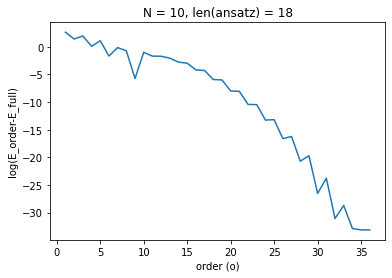

In [ ]:

thetas = np.random.random(len(ansatz))*np.pi/4
# thetas = [np.pi/4,np.pi/4]
# thetas = np.ones(len(ansatz))*np.pi/6
print(thetas)
E_full = Energy_matrix(N, matrix_H, matrix_ansatz, K, thetas)
G_K = G_k(N, H, ansatz, K)

E_order = []
o_max=len(ansatz)*2
s = s_dict(N, ansatz, K, o_max)
for o in range(1,o_max+1):
    E_approx = energy(thetas, ansatz, s, G_K, o)
    E_order += [E_approx]
    print(f"{o}/{o_max}")
print(E_order)
plt.plot(range(1,o_max+1), np.log(np.abs(E_order-E_full)))
plt.title(f"N = {N}, len(ansatz) = {len(ansatz)}")
plt.ylabel("log(E_order-E_full)")
plt.xlabel("order (o)")

In [ ]:

N = 10
ansatz = [pauli("X0Y1",N),pauli("X1Y2",N),pauli("X2Y3",N),pauli("X3Y4",N),pauli("X4Y5",N),pauli("X5Y6",N),pauli("X6Y7",N),pauli("X7Y8",N),pauli("X8Y9",N)]*2
Z_h = -1
X_h = -1
H = [pauli("Z0",N,Z_h),pauli("Z1",N,Z_h),pauli("Z2",N,Z_h),pauli("Z3",N,Z_h),pauli("Z4",N,Z_h),pauli("Z5",N,Z_h),pauli("Z6",N,Z_h),pauli("Z7",N,Z_h),pauli("Z8",N,Z_h),pauli("Z9",N,Z_h)]
H+=[pauli("X0X1",N,X_h),pauli("X1X2",N,X_h),pauli("X2X3",N,X_h),pauli("X4X5",N),pauli("X5X6",N),pauli("X6X7",N),pauli("X7X8",N),pauli("X8X9",N)]
K = [0]*18


# N = 7
# Z_h = -1
# X_h = -1
# ansatz = [pauli("X0Y1",N),pauli("Z1Z2",N), pauli("X2Y3",N),pauli("X3Y4",N),pauli("X4Y5",N),pauli("Z5Y6",N)]*2
# H = [pauli("Z0",N,Z_h),pauli("Z1",N,Z_h),pauli("X2",N,Z_h),pauli("Y3",N,Z_h),pauli("Z4",N,Z_h),pauli("Z5",N,Z_h),pauli("Y6",N,Z_h)]
# H+= [pauli("X0X1",N,X_h),pauli("X1X2",N,X_h),pauli("X2X3",N,X_h),pauli("X3X4",N,X_h),pauli("X4X5",N,X_h),pauli("X5X6",N,X_h)]
# K = [0]*len(ansatz)


# N = 3
# Z_h = -1
# X_h = -.01
# ansatz = [pauli("Z0Y1",N),pauli("X1Y2",N),pauli("Z0Z1",N)]
# H = [pauli("Z0",N,Z_h),pauli("Z1",N,Z_h),pauli("X2",N,Z_h)]
# H+= [pauli("X0X1",N,X_h),pauli("X1X2",N,X_h)]
# K = [0,1,1]





# N = 2
# Z_h = -1
# X_h = -1
# ansatz = [pauli("X0Y1",N),pauli("Z0I1",N)]
# H = [pauli("Z0",N,Z_h),pauli("Z1",N,Z_h)]
# H= [pauli("X0X1",N,X_h)]
# K = [0,1]



# N = 1
# Z_h = -1
# X_h = -1
# ansatz = [pauli("X0",N),pauli("Y0",N)]
# H = [pauli("Y0",N,Z_h)]
# K = [1,0]


matrix_ansatz = [t.matrix_repr() for t in ansatz]
matrix_H = sum([h.matrix_repr() for h in H])

